In [85]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import logging
from helper import getModelDict
delphesDir = os.path.abspath("./DelphesLLP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

c = 3e8

FORMAT = '%(levelname)s: %(message)s at %(asctime)s'
logging.basicConfig(format=FORMAT,datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger()

In [86]:
defaultPars = {'figure.figsize': (5, 4),
               'lines.markersize' : 4,
               'axes.titlesize' : 13,
               'font.size' : 13,
               'axes.labelsize' : 16,
               'xtick.labelsize' : 13,
               'ytick.labelsize' : 13,
               'legend.fontsize' : 10,
               "text.usetex": True,
               "font.family": "sans-serif",
               "font.sans-serif": ["Helvetica"],
               'font.family':'Times New Roman', 
               'font.serif':'Times New Roman',
               "savefig.dpi" : 300,
               'contour.linewidth' : 2.0,
               'lines.linewidth' : 2.0,
               'axes.grid' : True,
               'grid.linewidth' : 0.5,
               'grid.color' : 'lightgray',
               'axes.axisbelow' : True
               }
plt.rcParams.update(defaultPars)

### Files to be compared

In [93]:
filesDict = {
                r'No Matching' : './pp2chi0chi0_scan/Events/run_01/ddmH_mS_250_m1_122_dm_90_delphes_events.root',
                r'$Q_{cut} = M_{S}/5$' : './pp2chi0chi0J_scan/Events/run_01/ddmH_mS_250_m1_122_dm_90_delphes_events.root',
                r'$Q_{cut} = M_{S}/10$' : './pp2chi0chi0J_scan/Events/run_09/ddmH_mS_250_m1_122_dm_90_delphes_events.root',
}

modelDict = {}
for key,f in list(filesDict.items()):
    if not os.path.isfile(f):
        print(f'File {f} not found. Skipping.')
        filesDict.pop(key)
    else:
        modelDict[key] = getModelDict(f,verbose=False)

if len(set([tuple(d.items()) for d in modelDict.values()])) > 1:
    print('Several models being used!')
    mDict = None
else:
    mDict = list(modelDict.values())[0]


### Get kinematical variables for each file

In [61]:

cols = ['label',r'$M(S)$ (GeV)',r'$p_T(S)$ (GeV)',r'$E_T^{\rm miss}$ (GeV)']


dataList = []
for label,file in filesDict.items():   
    f = ROOT.TFile(file,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    for ievt in range(nevts):
        tree.GetEntry(ievt)

        pS = np.zeros(4)
        # Sum the LLP momenta (should correspond to the Sd momentum)
        for llp in tree.llpParticles:
            pS += np.array([llp.E,llp.Px,llp.Py,llp.Pz])
            if abs(llp.PID) != 4000023:
                print('wrong LLP',ievt)
                break

        met = tree.DMMissingET.At(0).MET
        mS = np.sqrt(pS[0]**2 - np.dot(pS[1:],pS[1:]))
        pT = np.sqrt(pS[1]**2 + pS[2]**2)
        dataList.append([label,mS,pT,met])
    
df = pd.DataFrame(columns=cols,data=dataList)
        

## Plot Distributions

/tmp/ipykernel_12380/1202003251.py:45: RuntimeWarning: invalid value encountered in divide
  r_y = np.divide(y,y0)
/tmp/ipykernel_12380/1202003251.py:46: RuntimeWarning: invalid value encountered in divide
  r_error = r_y*np.sqrt((yerr/y)**2 + (y0Err/y0)**2)
/tmp/ipykernel_12380/1202003251.py:45: RuntimeWarning: divide by zero encountered in divide
  r_y = np.divide(y,y0)


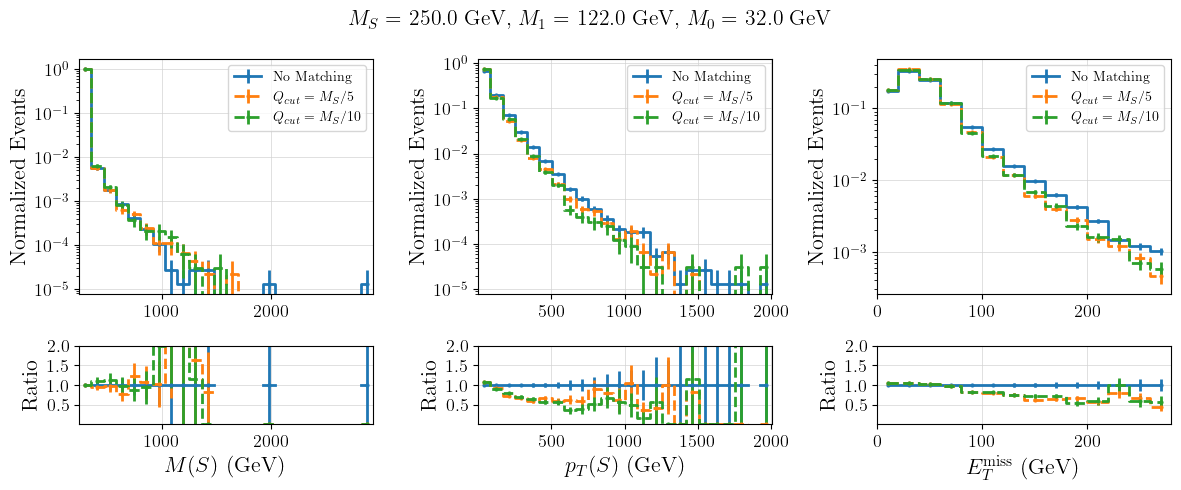

In [95]:
plot_variables = [c for c in df.columns if c not in ['label']]


ncols = len(plot_variables)
nrows = 2
fig,axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(4*ncols,2.5*nrows),
                        sharex=False, gridspec_kw = {'height_ratios':[3, 1]})
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

binsDict = {r'$E_T^{\rm miss}$ (GeV)' : np.arange(0.,300.,20.)}


for i,var in enumerate(plot_variables):
    v_max, v_min = df[var].max(),df[var].min()
    if var in binsDict:
        bins = binsDict[var]
    else:
        bins = np.linspace(v_min,v_max,25)
    # print(var,bins)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax = axes[0,i]
    ymax = 0.0
    for j,label in enumerate(df['label'].unique()):
        if 'No Matching' in label:
            ls = 'solid'
        else:
            ls = 'dashed'
        data = df[df['label'] == label]
        # print('b2=',bins)
        y,_ = np.histogram(data[var], bins=bins)
        yerr = np.sqrt(y)
        norm = sum(y)
        y = y/norm
        ymax = max(ymax,y.max())
        yerr = yerr/norm
        # print('bc=',bin_centers)
        p = ax.errorbar(bin_centers,y,yerr = yerr,marker = '.',drawstyle = 'steps-mid',
                 label=label,linewidth=2,linestyle=ls)
    
        # Plot ratios
        if j == 0:
            y0 = y
            y0Err = yerr
            
        r_y = np.divide(y,y0)
        r_error = r_y*np.sqrt((yerr/y)**2 + (y0Err/y0)**2)
        axes[1,i].errorbar(bin_centers,r_y,yerr = r_error,marker = '.',drawstyle = 'steps-mid',
                    label=label,linewidth=2,linestyle=ls,color=p[0].get_color())
        
    
    ax.set_ylabel('Normalized Events')
    ax.set_yscale('log')
    ax.set_xlim(min(bins),max(bins))
    if i >= 0:
        ax.legend()
    
    axes[1,i].set_xlabel(var)
    axes[1,i].set_ylabel('Ratio')
    axes[1,i].set_yticks([0.5,1.0,1.50,2.0])
    axes[1,i].set_ylim(0.,2.0)
    axes[1,i].set_xlim(min(bins),max(bins))
    # ax.set_ylim(0.0,1.1*ymax)

if mDict:
    fig.suptitle(r"$M_{S} =$ %1.1f GeV, $M_{1} = $ %1.1f GeV, $M_0 = $ %1.1f GeV" %(mDict['mS'],mDict['m1'],mDict['m0']))
plt.tight_layout()
plt.show()